In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [116]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

#for reference if you wanted to look at the tables joined

session = Session(engine)



In [117]:
# Create our session (link) from Python to the DB
session = Session(engine)
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

first_date = dt.date(int(last_date[0][:4]), int(last_date[0][5:7]), int(last_date[0][8:11])) - dt.timedelta(weeks=52)

sel1 = [Measurement.date, 
        Measurement.prcp]



date_prcp = session.query(*sel1).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date).all()


# Exploratory Climate Analysis

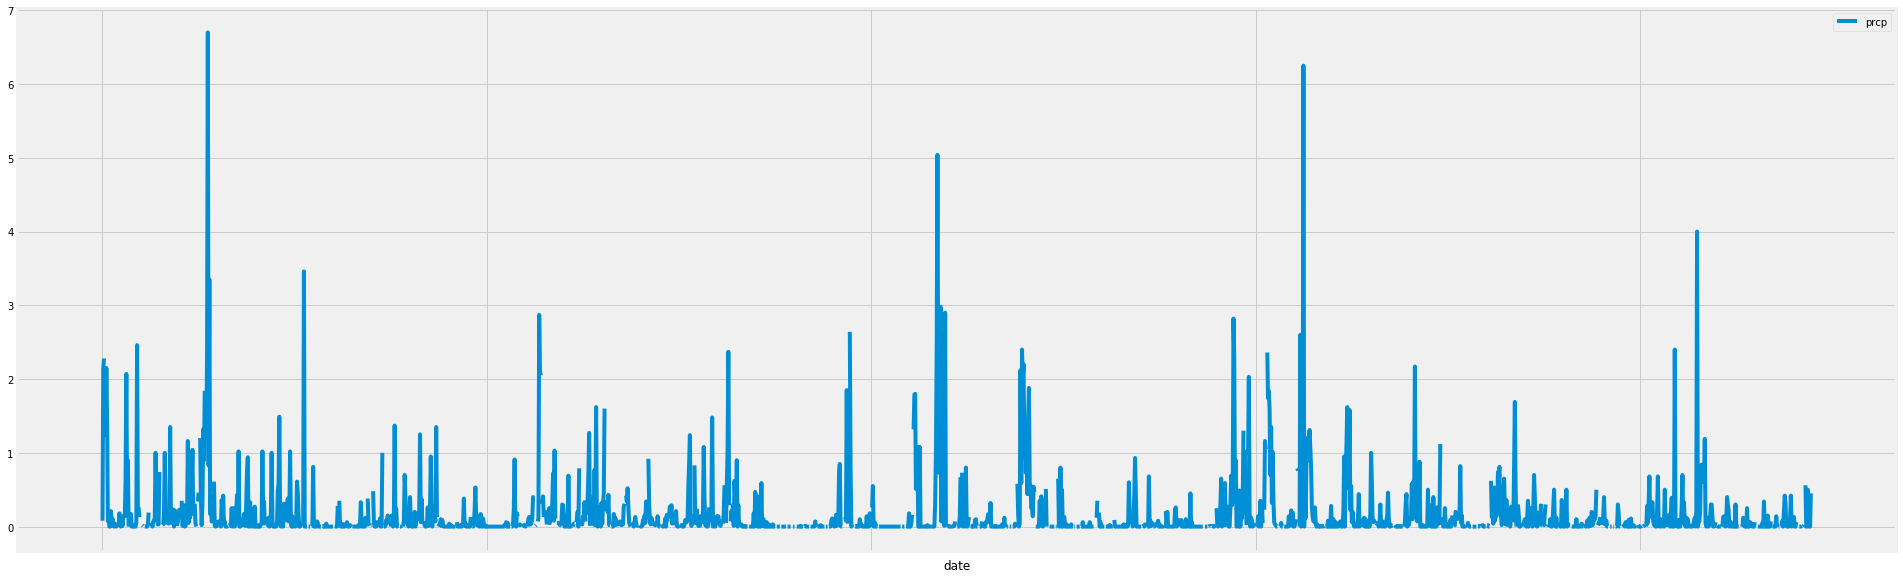

In [118]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

sel1 = [Measurement.date, 
        Measurement.prcp]


date_prcp = session.query(*sel1).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

first_date = dt.date(int(last_date[0][:4]), int(last_date[0][5:7]), int(last_date[0][8:11])) - dt.timedelta(weeks=52)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
        Measurement.prcp]
# Save the query results as a Pandas DataFrame 
date_prcp = session.query(*sel1).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date).all()

# Sort the dataframe by date and set the index to the date column
Date_Prcp_table = pd.DataFrame (date_prcp).sort_values(by='date')
Date_Prcp_table.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
Date_Prcp_table.plot(figsize=(30,10))

![precipitation](Images/precipitation.png)

In [119]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Date_Prcp_table.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [120]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [121]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
data = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)
        ]
temp_obser = session.query(*sel).all()
temp_obser

[(53.0, 87.0, 73.09795396419437)]

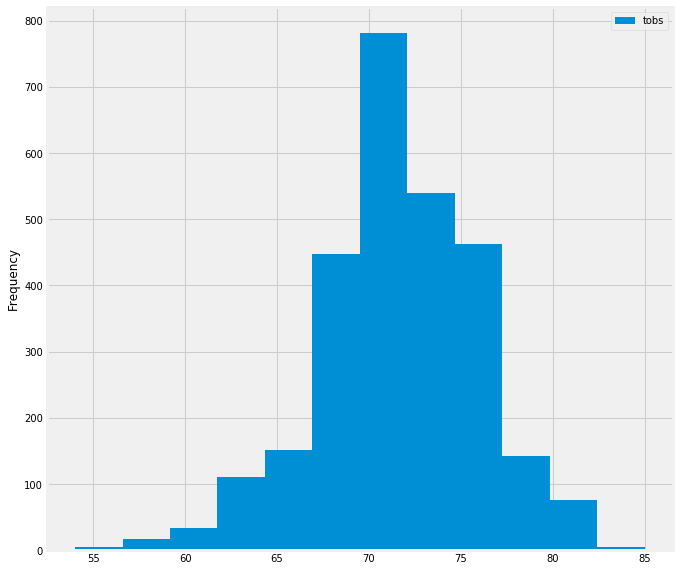

In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

stationMaxObs = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == 'USC00519281').all()
stationMaxObs

StationMaxObservations = pd.DataFrame (stationMaxObs).sort_values(by='tobs')


# Use Pandas Plotting with Matplotlib to plot the data
StationMaxObservations.plot(kind = 'hist', figsize=(10,10), bins = 12)

![precipitation](Images/station-histogram.png)

In [127]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

In [114]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calctemps = calc_temps('2017-04-20', '2017-04-30')
average = calctemps[0][1]

[(58.0, 73.08695652173913, 81.0)]

Text(0.5, 1.0, 'Trip Avg Temp')

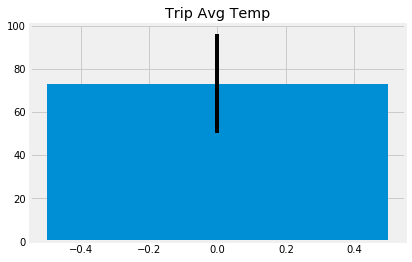

In [133]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title

# Use the average temperature for the y value 
average
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = (calctemps[0][2])-(calctemps[0][0])
plt.bar(x= 0, height = average, yerr = yerror, width = 1)
plt.title("Trip Avg Temp")



In [90]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfallPerWeatherStation = session.query(Measurement.prcp, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-04-20').\
    filter(Measurement.date <= '2017-04-30').order_by(Measurement.prcp.desc()).all()
print(rainfallPerWeatherStation)

[(6.25, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (2.6, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (2.36, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (1.84, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (1.74, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (1.58, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (1.35, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (1.31, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (1.21, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (1.17, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (1.16, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (1.05, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (1.0

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


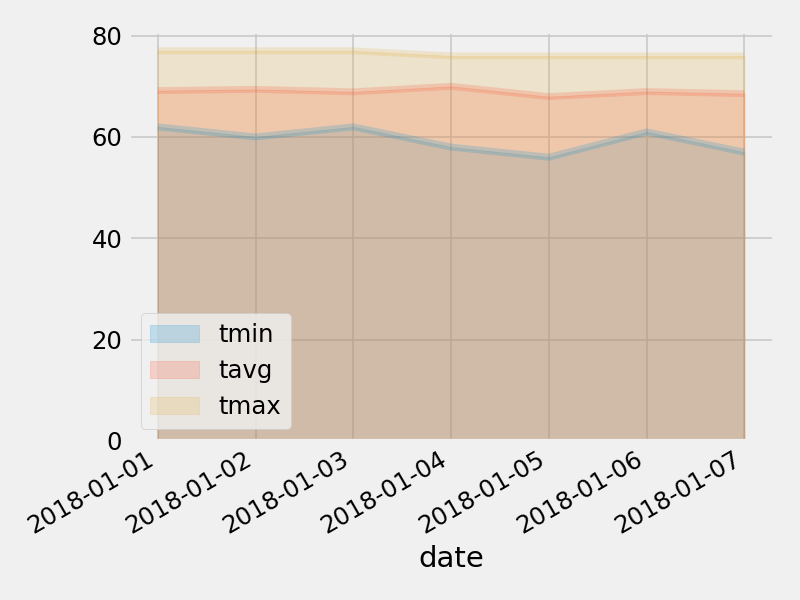

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
